The dataset is referenced as **Flickr Logos 27 Dataset**, which could be accessed using this url http://image.ntua.gr/iva/datasets/flickr_logos/  
     
The training data consists of **4536 images of logos belonging to 27 companies (168 for each)** along with the annotation of the location of the logo in the image. The test data (which will be referred to as **Query data** moving forward)however, only have labels and NOT the annotations of the location of the logos. 

In [124]:
# Importing libraries
import os
import re
import cv2
import joblib
import numpy as np
import pandas as pd
from PIL import ImageOps
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [125]:
### Reading annotations and labels for training data

train_img_label_file = os.path.join(os.getcwd(),
                                    "flickr_logos_27_dataset_training_set_annotation.txt")

train_images = pd.read_csv(train_img_label_file,
                           sep=' ', 
                           usecols = [i for i in range(7)],
                           header=None,  
                           names=["file_name",'label','subset','x1','y1','x2','y2'])

In [126]:
train_images.head()

,file_name,label,subset,x1,y1,x2,y2
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


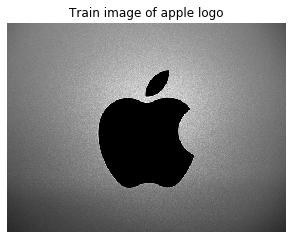

In [236]:
idx = 465
pth = 'data/'+train_images.loc[idx,'file_name']
image = Image.open(pth)
plt.imshow(image)
plt.axis("off")
plt.title("Train image of apple logo")
plt.show()

In [128]:
### Reading labels for test data

test_img_label_file = os.path.join(os.getcwd(), "flickr_logos_27_dataset_query_set_annotation.txt")

test_images = pd.read_csv(test_img_label_file,
                           sep='\t',
                           header=None,  
                           names=["file_name",'label'])

In [129]:
test_images.head()

,file_name,label
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas


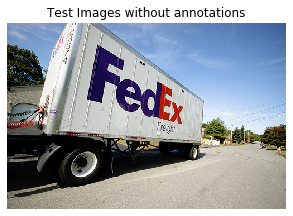

In [235]:
idx = 32
pth = 'data/'+test_images.loc[idx,'file_name']
image = Image.open(pth)
plt.imshow(image)
plt.axis("off")
plt.title("Test Images without annotations")
plt.show()

****

The target variable is **'label'**, which is the brand corresponding the particular image containing the logo. And the predictors are the 3 channel RGB values in a image.

Yes, the data is being pre-processed before being used in the training of a classifier. Following transformation would be done on the data :   
    
1. Cropping the image using the annotations (in case of trainig data)
2. Converting from RGB channel to grayscale (for dimensionality reduction)
3. Equalizing image histogram.
4. Randomly rotation the image 
5. Calculating Histogram of Oriented Gradient (HOG) of the image
6. Coversion of the image to a numpy array.
7. Normalizing and scaling the numpy array values using *Standard Scaler*

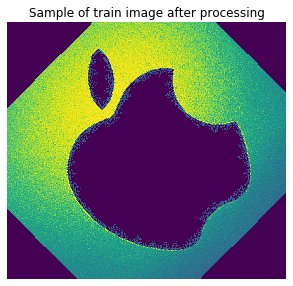

In [237]:
# Testing image processing methods 
# Cropping using annotations and changing it to greyscale along with equalizing
idx = 465
pth = 'data/'+train_images.loc[idx,'file_name']
image = Image.open(pth)
image = image.crop([train_images.loc[idx,'x1'],train_images.loc[idx,'y1'],train_images.loc[idx,'x2'],train_images.loc[idx,'y2']])
image = ImageOps.grayscale(image)
image = ImageOps.equalize(image)
image = image.rotate(45)

plt.imshow(image)
plt.axis('off')
plt.title("Sample of train image after processing")
plt.show()

***

## (D)

The supervised learning approach I'll be using is **Support vector machine (SVM)** classifier because it's highly effective in classifying high dimensional data. 
* Since the data is an image data pre-processed to 64 X 64 pixel image, which would generate 4096 dimension (which is still a lot), which then is passed through HOG to generate a 120 dimension vector, which is relatively low but still would be considered as high dimension. Based on my research, SVM appeared as the best model in case of image data when used in conjunction with HOG. The same is established in the model performance later in the project.

***

### Approach

* The $\textbf{training data}^1$ is processed as per the steps metioned in (C).
* The $\textbf{training data}^1$ is divided into $\textbf{train}^2$ and $\textbf{test}^2$. Following which, the $\textbf{train}^2$ is further divided for **K-fold cross validation** to check generalization performance of the model. 
* Once the K-fold check is done, the model is trained over the entire $\textbf{train}^2$ and the performance is measured over the $\textbf{test}^2$. 
* Following that the model is trained using the original $\textbf{training data}^1$ containing 4536 images, and performance is evaluated using the **Query data** (the non-annotated one). Given the **Query data** is not annotated, the model could perform poorly for this data (since the model is trained over exact logos without the surrouding noise.



## Data Pre-processing

In [182]:
#Cropping using annotations,changing it to greyscale along with equalizing and resizing

def image_processor(label_df,crop=True):
    '''
    function to read and pre process training images with labels
    Returns a numpy array of images
    '''
    angle = [0,45,90,135]
    #afine_tf = tf.AffineTransform(shear=0.2)
    train_img_arr = []
    num_images = len(label_df)
    for i in range(num_images):
        pth = 'data/'+label_df.loc[i,'file_name']
        image = Image.open(pth)
        if crop == True :
            x1 = train_images.loc[i,'x1']
            y1 = train_images.loc[i,'y1']
            x2 = train_images.loc[i,'x2']
            y2 = train_images.loc[i,'y2']
            image = image.crop([x1,y1,x2,y2])
        image = ImageOps.grayscale(image)
        image = ImageOps.equalize(image)
        #image = image.rotate(np.random.choice(angle))
        #if i%4 == 0:
        #    image = tf.warp(image, inverse_map=afine_tf)
        train_img_arr.append(np.asarray(image.resize([64,64]),dtype="int32")) 
    return np.array(train_img_arr)

In [ ]:
train_data = image_processor(train_images)
y = train_images['label']
train_data.shape

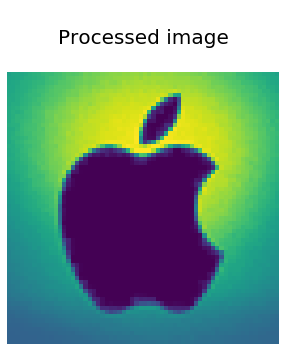

In [205]:
# resized processed image
plt.imshow(train_data[465])
plt.axis('off')   
plt.title("\nProcessed image\n", size=20)
plt.show()

## Applying HOG (Histogram of Oriented gradient)

In [206]:
from skimage import color
from skimage.feature import hog

In [207]:
ppc = 16
hog_images = []
hog_features = []
for image in train_data:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

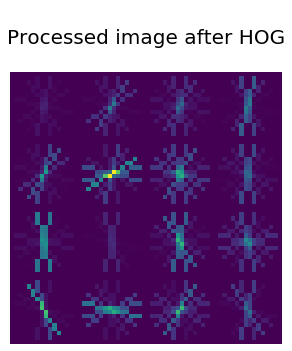

In [208]:
plt.imshow(hog_images[460])
plt.axis('off')   
plt.title("\nProcessed image after HOG\n", size=20)
plt.show()

In [ ]:
feature_vec_train = np.array(hog_features)
print(np.shape(feature_vec_train))

sc = StandardScaler()
feature_vec_train = sc.fit_transform(feature_vec_train)

### Creating  $\textbf{train}^2$ and  $\textbf{test}^2$ data from the original training set

In [210]:
X_train, X_test, y_train, y_test = train_test_split(feature_vec_train, y, test_size = 0.25, random_state = 21)

***

### Performing 10 fold cross validation on the  $\textbf{train}^2$ using SVM

In [219]:
clfs = svm.SVC()
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(feature_vec_train, y)

pred_score = np.empty(len(y),dtype='object')
plt.rcParams["figure.figsize"] = (5,5)

for train_index, test_index in skf.split(feature_vec_train, y):
    cross_X_train, cross_X_test = feature_vec_train[train_index], feature_vec_train[test_index]
    cross_y_train = y[train_index]

    
    clfs.fit(cross_X_train,cross_y_train)
    
    y_score = clfs.predict(cross_X_test)
    pred_score[test_index] = y_score

In [221]:
acckv = accuracy_score(y_true=y,y_pred= pred_score)
print("\nAccuracy after cross validation : %s percent"%(round(acckv,3)*100))


Accuracy after cross validation : 98.8 percent


The cross-validation yielded **98.8% accuracy** which shows the model overall generalization performance with annotated images is quite good.

### Training the classifier on the entire $\textbf{train}^2$ dataset and evaluated on $\textbf{test}^2$

In [218]:
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_true=y_test,y_pred= y_pred)
print("\nAccuracy with test data : %s percent"%(round(acc,3)*100))


Accuracy with test data : 97.8 percent


After training on the entire $\textbf{train}^2$ data, and testing the model performance on the $\textbf{test}^2$ data, the model yeilded **98.7% accuracy** which shows the model overall generalization performance with annotated images is quite good.

### Training the classifier on the entire  $\textbf{training}^1$ data and evaluating on non-annotated Query data 

   

In [ ]:
#Training the classifier on the actual training dataset with 4536 annotated logo images
clf = svm.SVC()
clf.fit(feature_vec_train, y)

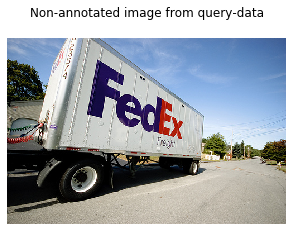

In [238]:
# sample of a non-annotated test images

idx = 32
pth = 'data/'+test_images.loc[idx,'file_name']
image = Image.open(pth)
plt.imshow(image)
plt.axis('off')
plt.title("Non-annotated image from query-data\n")
plt.show()

In [ ]:
test_data = image_processor(test_images, crop=False)
y_test_data = test_images['label']
#test_data.shape

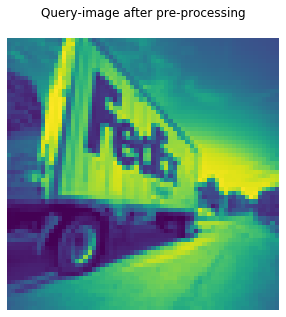

In [240]:
plt.imshow(test_data[32])
plt.axis('off')
plt.title('Query-image after pre-processing\n')
plt.show()

In [226]:
test_hog_images = []
test_hog_features = []
for image in test_data:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    test_hog_images.append(hog_image)
    test_hog_features.append(fd)

feature_vec_test = np.array(test_hog_features)

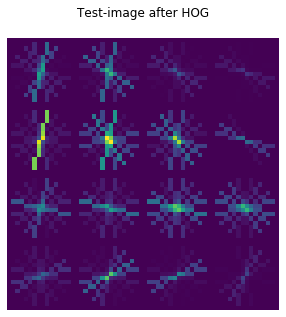

In [227]:
plt.imshow(test_hog_images[32])
plt.axis('off')
plt.title('Test-image after HOG\n')
plt.show()

In [228]:
feature_vec_test = sc.transform(feature_vec_test)
tes_pred = clf.predict(feature_vec_test)

In [230]:
acc_te = accuracy_score(y_true=y_test_data ,y_pred= tes_pred)
print("\nAccuracy with non-annotated test images : %s percent"%(round(acc_te,3)*100))


Accuracy with non-annotated test images : 11.1 percent


As expected, the model performed **very poorly** with the **non-annotated query data**, which is primarily due to location of the logo within the image.

******

* Based on the analysis, it appearead when working with the annotated data and cropping the image, the model performed very good at 98% accuracy rate both in cross-validation, and with the test data.
* However, the poor performance with the original non-annotated test data could be attributed to the noise in the image surroundings the logo. Since the model was trained on the cropped images, containing only logos, the model 
* In order to improve the performance, the test data needs to be processed through an **object recognition algorithm**, which would detect the logo within an image, which then could be pass through this classifier. 
* Also, given the object recognition, following future work could be done :    
> * To improve the prediction algorithm performance over large number of logos (not just 27), convolutional neural network could be used
> * Additional functionality could be added to address the original problem (detecting phishing website). This could be achieved using screen scrapping and downloding images from a web url and then predicting if the logo matches to a certain brand or not.

****
$\hspace{16cm}END$
****